In [23]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models

from imutils import paths
from pathlib import Path
import os
import sys
import time
import copy

import pandas as pd
import matplotlib.pylab as plt
import numpy as np
from scipy.signal import savgol_filter

# Local modules
from cub_tools.train import train_model
from cub_tools.visualize import imshow, visualize_model
from cub_tools.utils import unpickle, save_pickle
from cub_tools.transforms import makeDefaultTransforms
from cub_tools.optim import learning_rate_optimizer

In [2]:
# Script runtime options
model = 'resnet152'
model_func = models.resnet152
data_root_dir = '../data'
model_root_dir = '../models'
stages = ['train', 'test']
batch_size = 8
lr_range = (1.0E-05, 1.0)

# Paths setup
data_dir = os.path.join(data_root_dir,'images')
output_dir = os.path.join(model_root_dir,'classification/{}'.format(model))
model_history = os.path.join(output_dir,'model_history.pkl')
model_file = os.path.join(output_dir, 'caltech_birds_{}_full.pth'.format(model))

In [3]:
# Get data transforms
data_transforms = makeDefaultTransforms()

In [4]:
# Setup data loaders with augmentation transforms
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in stages}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in stages}
dataset_sizes = {x: len(image_datasets[x]) for x in stages}
class_names = image_datasets[stages[0]].classes

print('Number of data')
print('========================================')
for dataset in dataset_sizes.keys():
    print(dataset,' size:: ', dataset_sizes[dataset],' images')

Number of data
train  size::  5994  images
test  size::  5794  images


In [5]:
# Setup the device to run the computations
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device::', device)

Device:: cuda:0


In [6]:
model_ft = model_func(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr_range[0], momentum=0.9)

In [7]:
lr, lr_loss = learning_rate_optimizer(model=model_ft, criterion=criterion, optimizer=optimizer_ft, 
                                      device=device, dataloaders=dataloaders, 
                                      lr_range=lr_range, num_epochs=2, smoothing=0.05, verbose=True)

epoch 0
[ITER] Epoch: 0 :: Batch: 0 :: LR: 1.0077048141361044e-05 :: Loss 5.475733757019043
[ITER] Epoch: 0 :: Batch: 50 :: LR: 1.4791083881682075e-05 :: Loss 5.372005462646484
[ITER] Epoch: 0 :: Batch: 100 :: LR: 2.171034208886955e-05 :: Loss 5.3638014793396
[ITER] Epoch: 0 :: Batch: 150 :: LR: 3.186642421786731e-05 :: Loss 5.3101091384887695
[ITER] Epoch: 0 :: Batch: 200 :: LR: 4.677351412871981e-05 :: Loss 5.32636022567749
[ITER] Epoch: 0 :: Batch: 250 :: LR: 6.865412978224548e-05 :: Loss 5.301204681396484
[ITER] Epoch: 0 :: Batch: 300 :: LR: 0.00010077048141361042 :: Loss 5.322935581207275
[ITER] Epoch: 0 :: Batch: 350 :: LR: 0.00014791083881682076 :: Loss 5.3282012939453125
[ITER] Epoch: 0 :: Batch: 400 :: LR: 0.00021710342088869546 :: Loss 5.274873733520508
[ITER] Epoch: 0 :: Batch: 450 :: LR: 0.00031866424217867314 :: Loss 5.267598628997803
[ITER] Epoch: 0 :: Batch: 500 :: LR: 0.0004677351412871982 :: Loss 5.244722366333008
[ITER] Epoch: 0 :: Batch: 550 :: LR: 0.0006865412978224

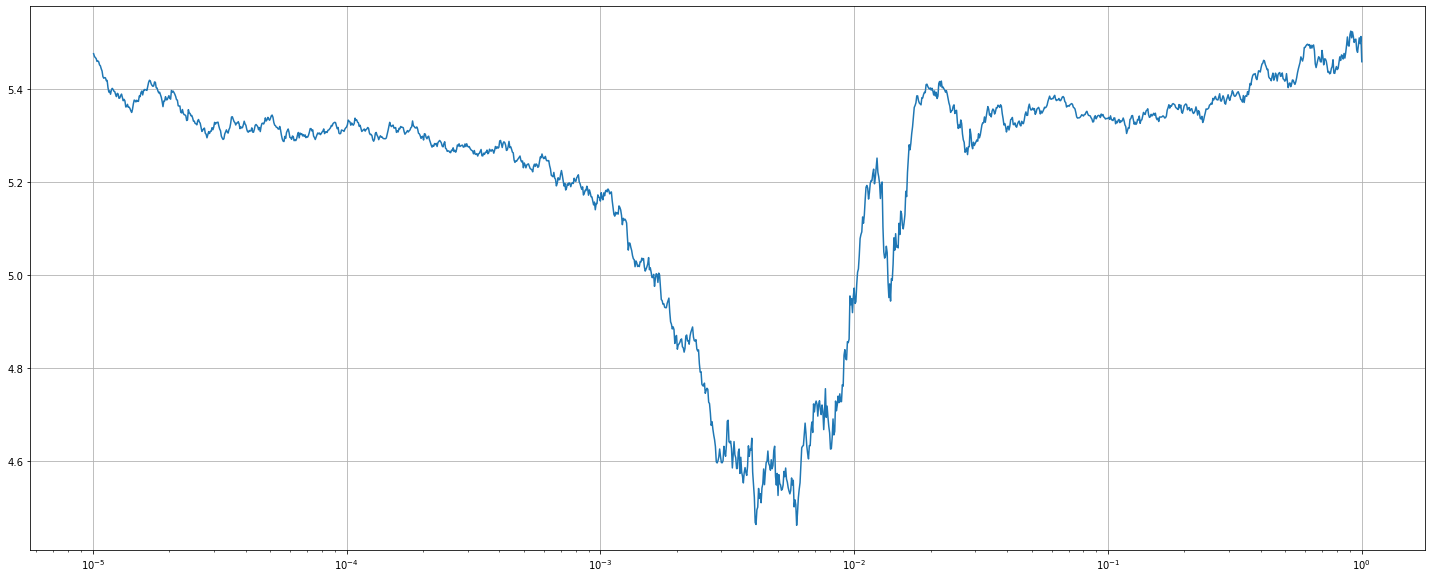

In [15]:
plt.figure(figsize=(25,10))
plt.plot(lr, lr_loss)
plt.grid(True)
plt.xscale('log')
plt.show()

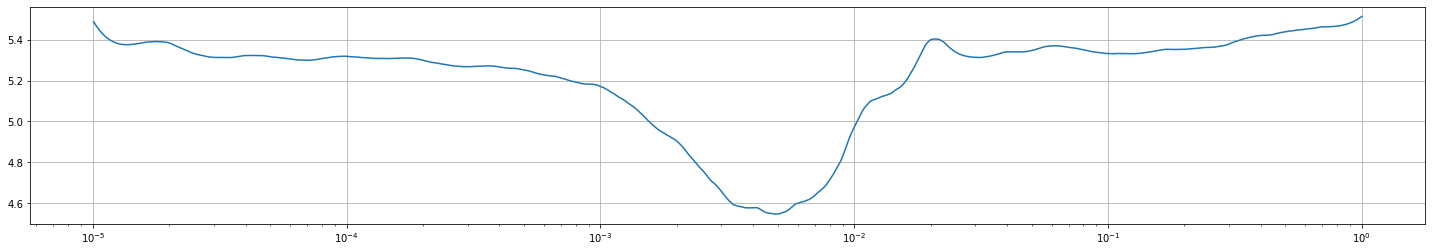

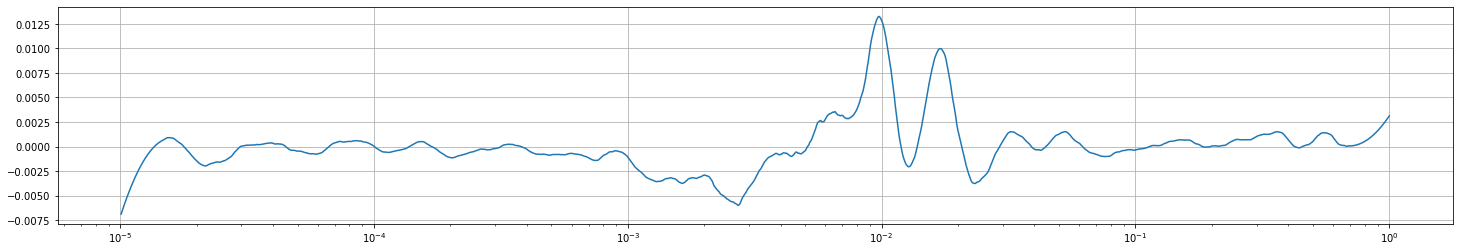

In [37]:
plt.figure(figsize=(25,4))
plt.plot(lr, savgol_filter(lr_loss,window_length=99, polyorder=3, deriv=0))
plt.grid(True)
plt.xscale('log')
plt.show()

plt.figure(figsize=(25,4))
plt.plot(lr, savgol_filter(lr_loss,window_length=99, polyorder=3, deriv=1))
plt.grid(True)
plt.xscale('log')
plt.show()

In [8]:
model_ft = model_func(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=lr_range[0], betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

In [9]:
lr_adam, lr_loss_adam = learning_rate_optimizer(model=model_ft, criterion=criterion, optimizer=optimizer_ft, 
                                                device=device, dataloaders=dataloaders, 
                                                lr_range=lr_range, num_epochs=2, smoothing=0.05, verbose=True)

epoch 0
[ITER] Epoch: 0 :: Batch: 0 :: LR: 1.0077048141361044e-05 :: Loss 5.223827362060547
[ITER] Epoch: 0 :: Batch: 50 :: LR: 1.4791083881682075e-05 :: Loss 5.314944744110107
[ITER] Epoch: 0 :: Batch: 100 :: LR: 2.171034208886955e-05 :: Loss 5.3121161460876465
[ITER] Epoch: 0 :: Batch: 150 :: LR: 3.186642421786731e-05 :: Loss 5.256424427032471
[ITER] Epoch: 0 :: Batch: 200 :: LR: 4.677351412871981e-05 :: Loss 5.135632514953613
[ITER] Epoch: 0 :: Batch: 250 :: LR: 6.865412978224548e-05 :: Loss 4.990912437438965
[ITER] Epoch: 0 :: Batch: 300 :: LR: 0.00010077048141361042 :: Loss 4.795492172241211
[ITER] Epoch: 0 :: Batch: 350 :: LR: 0.00014791083881682076 :: Loss 4.629088878631592
[ITER] Epoch: 0 :: Batch: 400 :: LR: 0.00021710342088869546 :: Loss 4.542047500610352
[ITER] Epoch: 0 :: Batch: 450 :: LR: 0.00031866424217867314 :: Loss 4.62437629699707
[ITER] Epoch: 0 :: Batch: 500 :: LR: 0.0004677351412871982 :: Loss 5.109602451324463
[ITER] Epoch: 0 :: Batch: 550 :: LR: 0.000686541297822

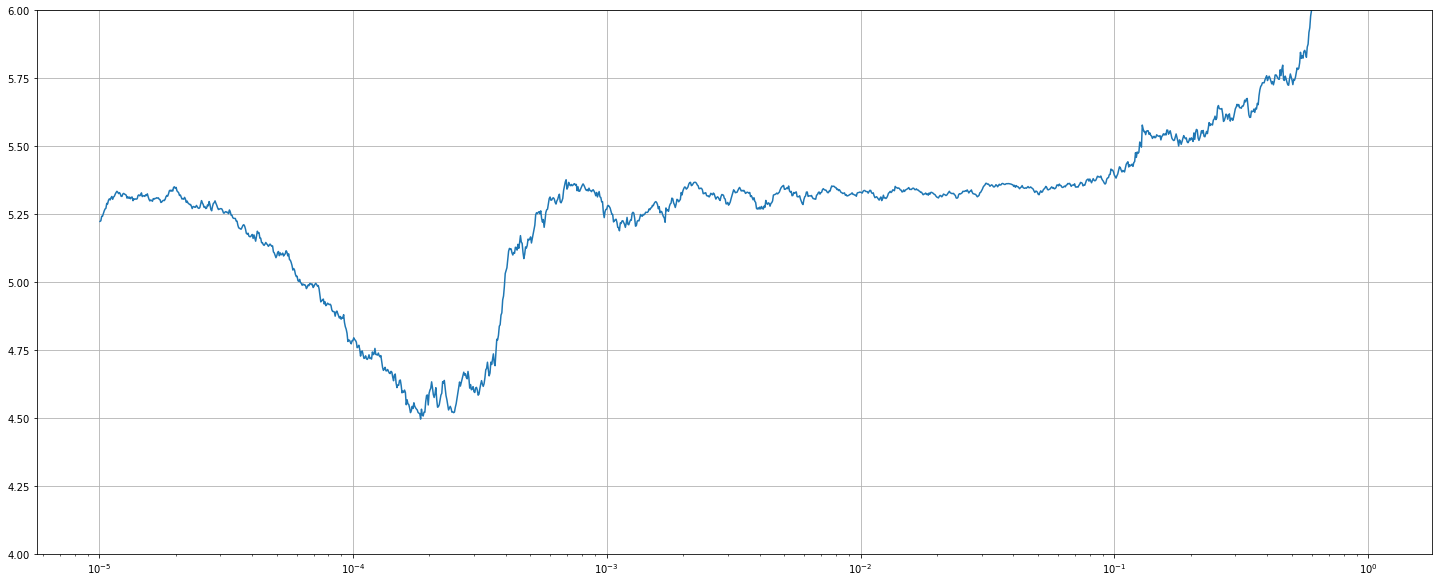

In [22]:
plt.figure(figsize=(25,10))
plt.plot(lr_adam, lr_loss_adam)
plt.grid(True)
plt.xscale('log')
plt.ylim([4, 6])
plt.show()

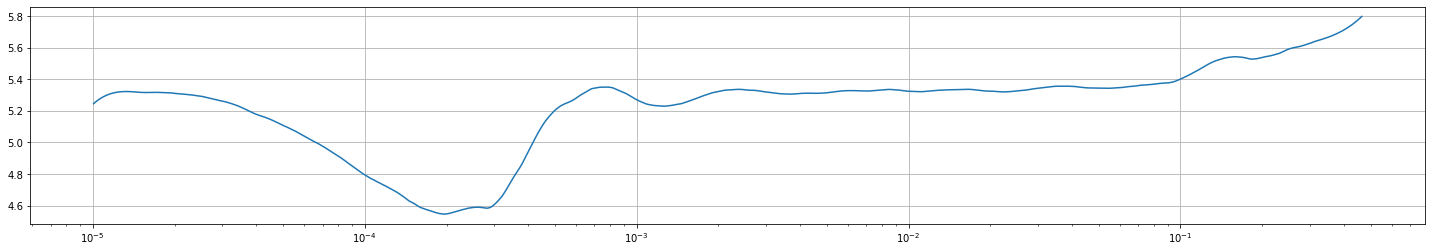

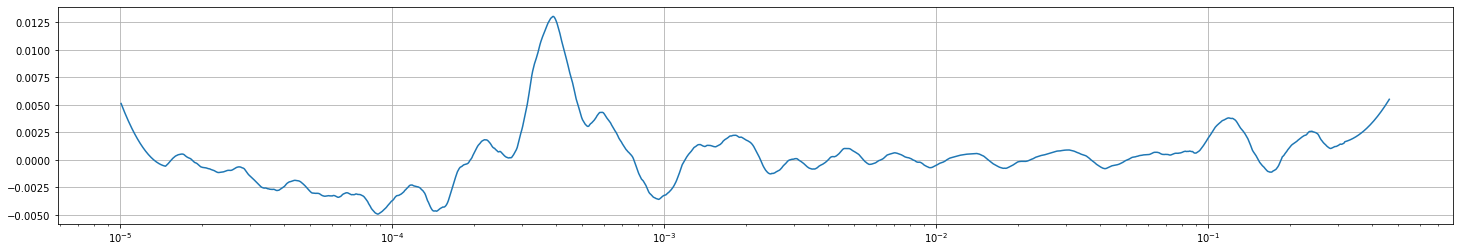

In [36]:
plt.figure(figsize=(25,4))
plt.plot(lr[:-100], savgol_filter(lr_loss_adam[:-100],window_length=99, polyorder=3, deriv=0))
plt.grid(True)
plt.xscale('log')
plt.show()

plt.figure(figsize=(25,4))
plt.plot(lr[:-100], savgol_filter(lr_loss_adam[:-100],window_length=99, polyorder=3, deriv=1))
plt.grid(True)
plt.xscale('log')
plt.show()
